<a href="https://colab.research.google.com/github/weilainicolas/Deep-Learning/blob/master/L7_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [2]:
path = untar_data(URLs.PETS)
path_hr=path/'images'
path_lr=path/'crappy'

In [0]:
path_hr

PosixPath('/root/.fastai/data/oxford-iiit-pet/image')

In [0]:
from PIL import Image, ImageDraw, ImageFont

In [0]:
def crappify(fn, i):
  dest=path_lr/fn.relative_to(path_hr)
  dest.parent.mkdir(parents=True, exist_ok=True)
  img=PIL.Image.open(fn)
  targ_sz=resize_to(img,96,use_min=True)
  img=img.resize(targ_sz,resample=PIL.Image.BILINEAR).convert('RGB')
  w,h=img.size
  q=random.randint(10,70)
  ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)),str(q),fill=(255,255,255))
  img.save(dest,quality=q)


In [5]:
il =ImageList.from_folder(path_hr)
parallel(crappify,il.items)

In [0]:
bs,size=32,128
arch=models.resnet34

In [0]:
src=ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1,seed=42)

In [0]:
path_hr/src.items[0].name

PosixPath('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_167.jpg')

In [0]:
def get_data(bs,size):
  data=(src.label_from_func(lambda x: path_hr/x.name)
        .transform(get_transforms(max_zoom=2), size=size, tfm_y=True)
        .databunch(bs=bs).normalize(imagenet_stats,do_y=True))
  data.c=3
  return data

In [0]:
data=get_data(bs,size)

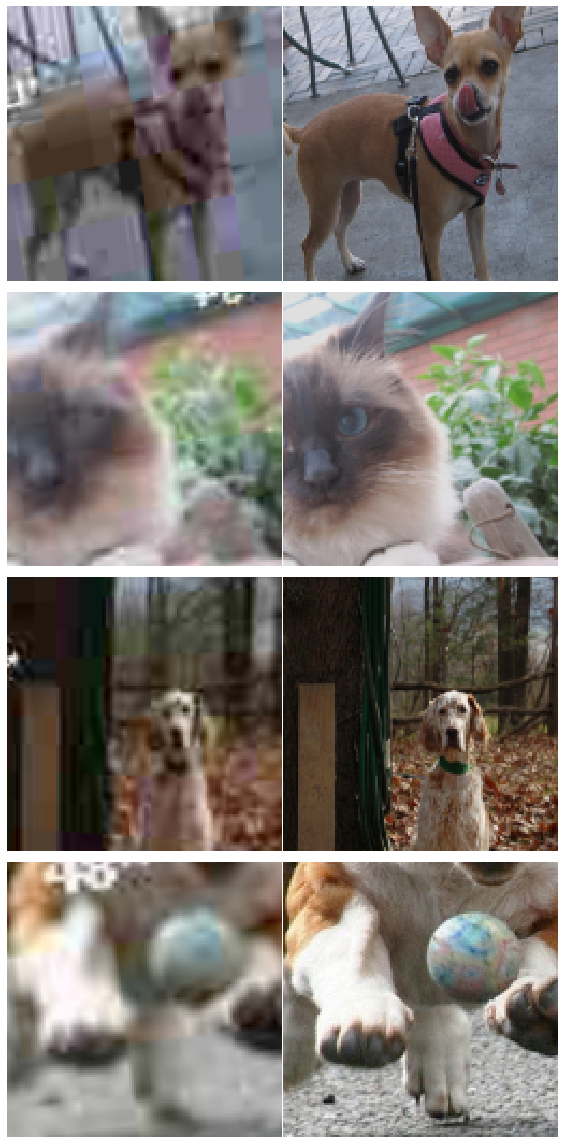

In [10]:
data.show_batch(4)

In [0]:
wd=1e-3

In [0]:
y_range=(-3.,3.)
loss_gen=MSELossFlat()

In [0]:
def create_gen_learner():
  return unet_learner(data,arch,wd=wd,blur=True,norm_type=NormType.Weight,self_attention=True,y_range=y_range,loss_func=loss_gen)

In [14]:
learn_gen=create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 186MB/s]


In [15]:
learn_gen.fit_one_cycle(2,pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.072761,0.055948,02:04
1,0.052877,0.050274,02:00


In [0]:
learn_gen.unfreeze()

In [17]:
learn_gen.fit_one_cycle(4,slice(1e-6,1e-3))

epoch,train_loss,valid_loss,time
0,0.051892,0.049613,02:02
1,0.049338,0.047467,02:03
2,0.047642,0.045979,02:03
3,0.046976,0.045452,02:03


In [0]:
learn_gen.save('gen_pre')

In [0]:
name_gen='image_gen'
path_gen=path/name_gen

In [0]:
path_gen.mkdir(exist_ok=True)

In [0]:
def save_preds(dl):
  i=0
  names=dl.dataset.items
  for b in dl:
    preds=learn_gen.pred_batch(batch=b,reconstruct=True)
    for o in preds:
      o.save(path_gen/names[i].name)
      i+=1

In [0]:
save_preds(data.fix_dl)

In [27]:
data

ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/oxford-iiit-pet/crappy;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/oxford-iiit-pet/crappy;

Test: None

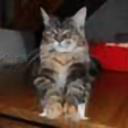

In [24]:
PIL.Image.open(path_gen.ls()[0])

```Train Critic```

In [35]:
learn_gen=None
gc.collect()

5199

In [37]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/crappy'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/image_gen')]

In [0]:
def get_crit_data(classes,bs,size):
  src=ImageList.from_folder(path,include=classes).split_by_rand_pct(0.1, seed=42)
  il=src.label_from_folder(classes=classes)
  data=(il.transform(get_transforms(max_zoom=2.),size=size).databunch(bs=bs).normalize(imagenet_stats))
  data.c=3
  return data

In [0]:
data_crit=get_crit_data([name_gen,'images'],bs=bs,size=size)

In [90]:
data_crit.train_ds

LabelList (12637 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
images,images,images,images,images
Path: /root/.fastai/data/oxford-iiit-pet

In [0]:
loss_crit=AdaptiveLoss(nn.BCEWithLogitsLoss())

In [0]:
def create_crit_learner(data,metrics):
  return Learner(data,gan_critic(),metrics=metrics,loss_func=loss_crit,wd=wd)

In [0]:
crit_learner=create_crit_learner(data_crit,accuracy_thresh_expand)

In [94]:
crit_learner.fit_one_cycle(6,1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.637748,0.602762,0.679915,02:22
1,0.250897,0.566410,0.781367,02:19
2,0.150656,0.061357,0.981254,02:20
3,0.078526,0.382287,0.839430,02:19
4,0.048273,0.070036,0.975185,02:19
5,0.038250,0.059590,0.982821,02:19


In [0]:
crit_learner.save('crit_pre')

GAN

In [96]:
crit_learner=None
learn_gen=None
gc.collect()

14606

In [0]:
data_crit=get_crit_data(['crappy','images'],bs=bs,size=size)
learn_crit=create_crit_learner(data_crit,metrics=None).load('crit_pre')
learn_gen=create_gen_learner().load('gen_pre')

In [0]:
switcher=partial(AdaptiveGANSwitcher,critic_thresh=0.65)
learn=GANLearner.from_learners(learn_gen,learn_crit,weights_gen=(1.,50.),show_img=False,switcher=switcher,
                               opt_func=partial(optim.Adam,betas=(0.,0.99)),wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR,mult_lr=5.))

In [0]:
lr=1e-4

In [106]:
learn.fit(40,lr)

KeyboardInterrupt: ignored